# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

import scipy.constants
from scipy.special import sph_harm

from sympy.physics.wigner import wigner_3j

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["text.usetex"] = True
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# Define constants

In [2]:
# Physical Constants
H_BAR = scipy.constants.hbar

# Molecular Constants
D_0 = 1.225 * 3.33564e-30  # Molecular dipole moment (C.m)
B_0 = 490.173994326310e6 * scipy.constants.h  # B_0 := H_BAR^2/2I

# Global Computational Constants
N_MAX = 7  #  No. of Rotational base states 0 <= N <= N_MAX

E_MIN = 1e-2  # Min E Field in kV/cm, non-zero to stop 3-fold degeneracy at 0 field.
E_MAX = 20  # Max E Field in kV/cm
E_STEPS = 200  # Resolution of E Field range

POLAR_PLOT_RES = 50

# Derived Constants
STATE_COUNT = 1 + 2 * N_MAX + N_MAX**2
N_COLOURS = cm.rainbow(np.linspace(0, 1, N_MAX + 1))

# Create empty Hamiltonians to be expanded in ordered basis:
|0,0> |1,-1>  |1,+1> |1,0> |2,-2>  |2,+2> ....
Each N has 2N+1 degeneracy at 0 E-field. Counting the number of states:
$$
\sum_{N=0}^{N_{MAX}} 2N + 1 = 1 + 2\sum_{N=1}^{N_{MAX}} N + \sum_{N=1}^{N_{MAX}} 1 = 1 + N_{MAX}(N_{MAX}+1) + N_{MAX} = 1 + 2N_{MAX} + N_{MAX}^2
$$

In [3]:
Hrot = np.zeros((STATE_COUNT, STATE_COUNT), dtype=np.cdouble)
Hdc = np.zeros((STATE_COUNT, STATE_COUNT), dtype=np.cdouble)
Hsplit = np.zeros((STATE_COUNT, STATE_COUNT), dtype=np.cdouble)

# Nice enumeration over states
We somehow want to be able to iterate over states and have at once,
their label |N,m> and also their position in the matrix. Let's define a new interator...

In [4]:
def state_iter(to_N):
    s = 0
    for N in range(0, to_N + 1):
        for M in range(N, 0, -1):
            yield s, N, -M
            s += 1
            yield s, N, +M
            s += 1
        yield s, N, 0
        s += 1


def state_to_pos(N, M):
    for i, Ni, Mi in state_iter(N):
        if N == Ni and M == Mi:
            return i

# Populate Rotational Hamiltonian
$$
H_{rot}=\frac{J^2}{2I}=\frac{J^2}{2\mu R^2}
$$
Which has spherical harmonic solutions
$$
\frac{J^2}{2I} |Y_{l,m}> = \frac{\hbar^2}{2I} l(l+1) |Y_{l,m}>
$$
$$
E_{l,m} = \frac{\hbar^2}{2I} l(l+1) = B_0 l(l+1)
$$
Expanding in spherical harmonic basis
$$
<Y_{l',m'}|H_{rot}|Y_{l,m}> =
\begin{cases}
    B_0 l(l+1), & \text{if}\ l'=l, m'=m \\
    0, & \text{otherwise}
\end{cases}
$$

In [5]:
for i, N, M in state_iter(N_MAX):
    Hrot[i, i] = B_0 * N * (N + 1)

# Populate DC Stark Hamiltonian
$$H_{st} = -\bf{d}\cdot\bf{\epsilon} = -\epsilon\bf{d}\cdot\bf{\hat{z}} = -\epsilon d_{mol} \cos\theta$$
$$<Y_{l',m'}|H_{st}|Y_{l,m}> = -d_0\epsilon\int\int Y_{l',m'}^* \cos\theta Y_{l,m}$$
using the following identity where the bracketed terms are compact notation for Wigner-3j coefficients
$$\int\int Y_{A,i}(\theta,\phi)Y_{B,j}(\theta,\phi)Y_{C,k}(\theta,\phi) d^2\Omega =
\left[\frac{(2A+1)(2B+1)(2C+1)}{4\pi}\right]^{\frac{1}{2}}
\begin{pmatrix}
A & B & C\\
0 & 0 & 0
\end{pmatrix}
\begin{pmatrix}
A & B & C\\
i & j & k
\end{pmatrix}
$$
Along with the fact
$$ cos\theta = Y_{1,0}\sqrt{\frac{4\pi}{3}}$$
we get
$$<Y_{l',m'}|H_{st}|Y_{l,m}> = -d_0\epsilon\sqrt{(2l+1)(2l'+1)}(-1)^{m'}
\begin{pmatrix}
l' & 1 & l\\
-m' & 0 & m
\end{pmatrix}
\begin{pmatrix}
l' & 1 & l\\
0 & 0 & 0
\end{pmatrix}$$
This has non-zero elements only for $\Delta l = \pm 1$ and $\Delta m = 0$ 

In [6]:
for i, N1, M1 in state_iter(N_MAX):
    for j, N2, M2 in state_iter(N_MAX):
        Hdc[i, j] = (
            -D_0
            * np.sqrt((2 * N1 + 1) * (2 * N2 + 1))
            * (-1) ** M1
            * wigner_3j(N1, 1, N2, -M1, 0, M2)
            * wigner_3j(N1, 1, N2, 0, 0, 0)
        )

# Split degeneracy for solver
We will also add a minor splitting between states with the same $|M_N|$.
Otherwise since they have degenerate energies, the solver can arbitrarily pick a different spanning basis 
of $|N,M_N>\otimes|N,-M_N>$.

In [7]:
for i, N, M in state_iter(N_MAX):
    if M < 0:
        Hsplit[i, i] = -1e-33
    if M > 0:
        Hsplit[i, i] = 1e-33

# Form and Diagonalise total Hamiltonian

In [8]:
E = np.linspace(E_MIN, E_MAX, E_STEPS) * 1e5  # -> V/m
Htot = Hrot[..., None] + Hdc[..., None] * E + Hsplit[..., None]
Htot = Htot.transpose(2, 0, 1)

energies, states = eigh(Htot)

# Sort states
The `eigh` function sorts the states by increasing energy and so will rearange order of vectors

In [9]:
def sort_smooth(in_energies, in_states):
    """Sort states to remove false avoided crossings.

    This is a function to ensure that all eigenstates plotted change
    adiabatically, it does this by assuming that step to step the eigenstates
    should vary by only a small amount (i.e. that the  step size is fine) and
    arranging states to maximise the overlap one step to the next.

    Args:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy
    Returns:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy E[x,i] -> States[x,:,i]
    """
    ls = np.arange(in_states.shape[2], dtype="int")
    number_iterations = len(in_energies[:, 0])
    for i in range(1, number_iterations):
        """
        This loop sorts the eigenstates such that they maintain some
        continuity. Each eigenstate should be chosen to maximise the overlap
        with the previous.
        """
        # calculate the overlap of the ith and jth eigenstates
        overlaps = np.einsum(
            "ij,ik->jk", np.conjugate(in_states[i - 1, :, :]), in_states[i, :, :]
        )
        orig2 = in_states[i, :, :].copy()
        orig1 = in_energies[i, :].copy()
        # insert location of maximums into array ls
        np.argmax(np.abs(overlaps), axis=1, out=ls)
        for k in range(in_states.shape[2]):
            l = ls[k]
            if l != k:
                in_energies[i, k] = orig1[l].copy()
                in_states[i, :, k] = orig2[:, l].copy()
    return in_energies, in_states


energies, states = sort_smooth(energies, states)

# Looking at Coefficient mixing (debug)

<IPython.core.display.Javascript object>


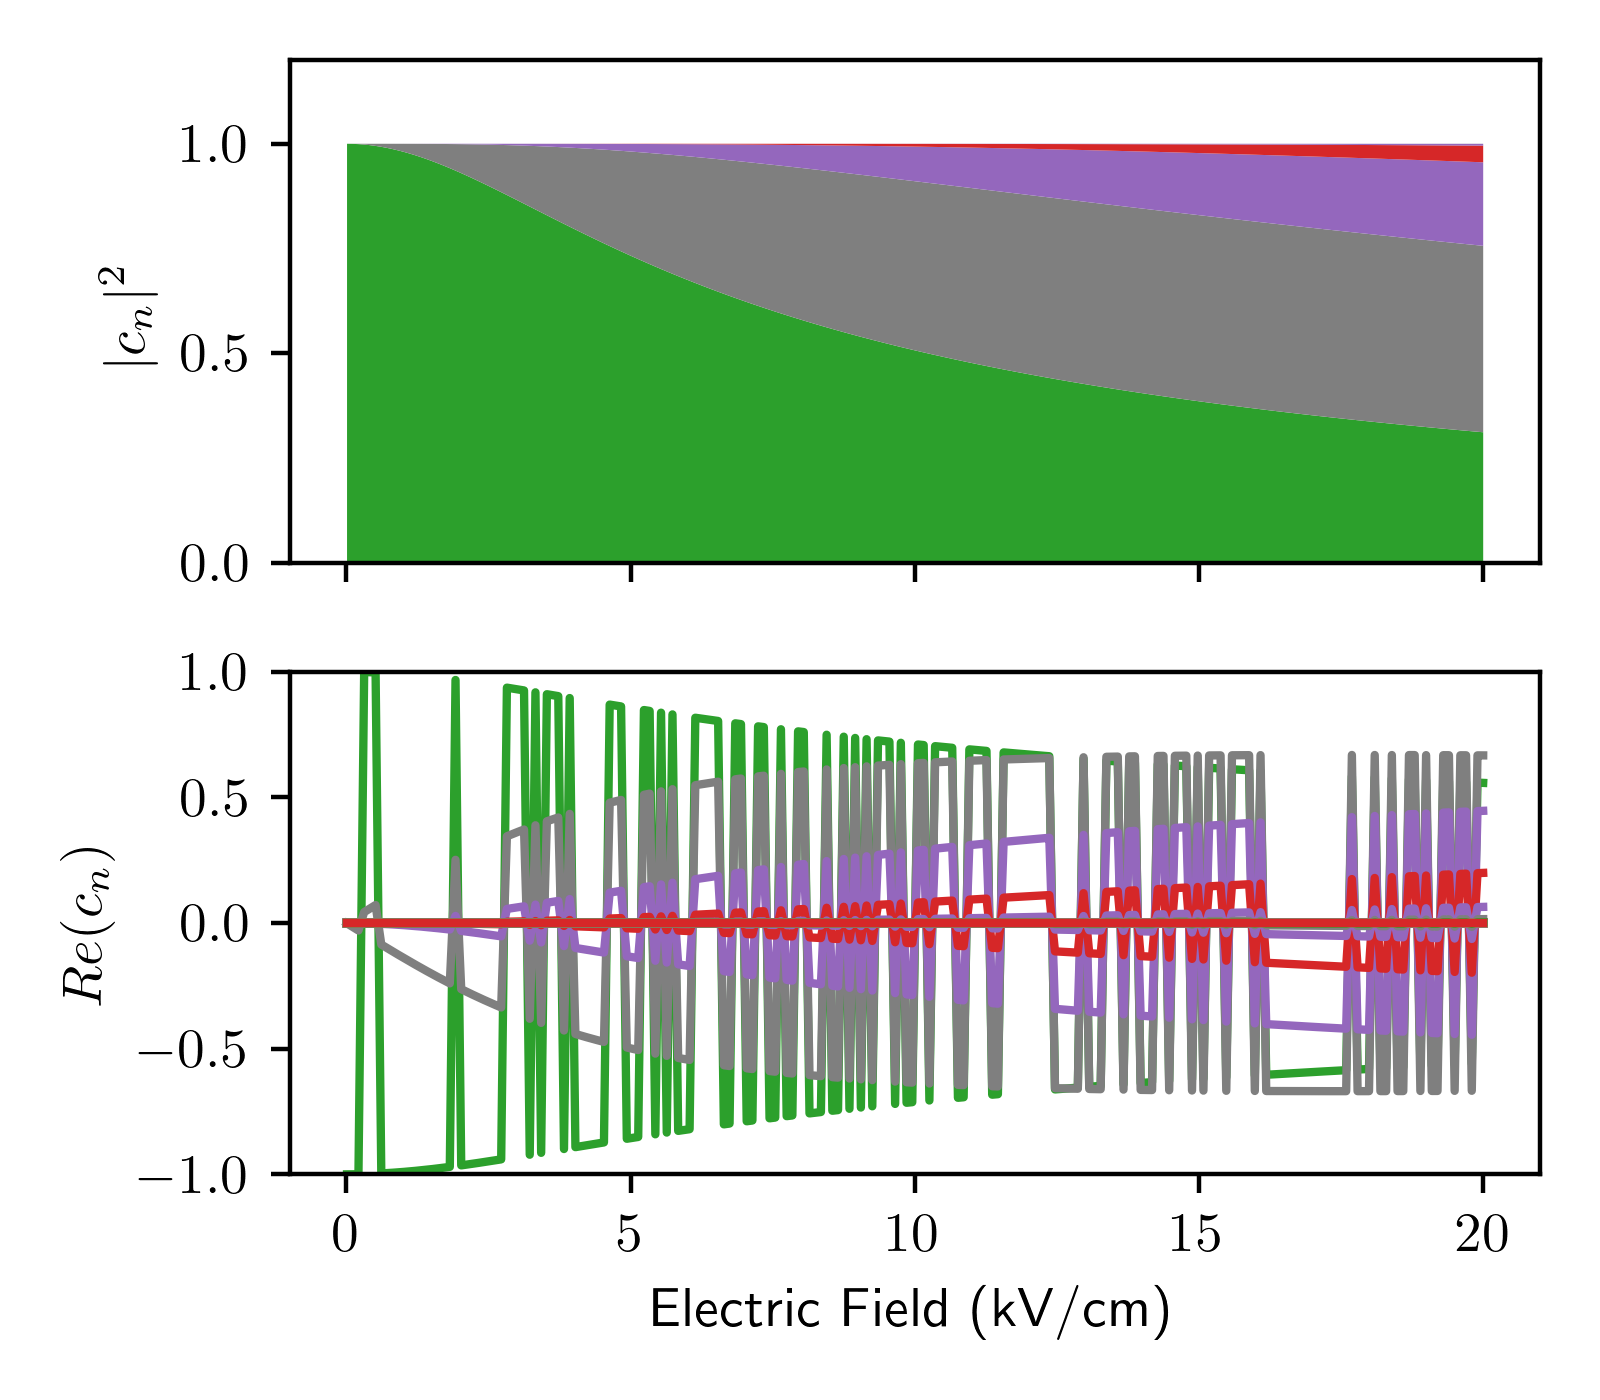

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

state = state_to_pos(1, 1)
probs, reals = [], []
for coefn in range(STATE_COUNT):
    probs.append(np.abs(states[:, coefn, state]) ** 2)
    reals.append(states[:, coefn, state].real)

ax1.stackplot(E * 1e-5, probs)
ax1.set_ylabel(r"$|c_n|^2$")
ax1.set_ylim(0, 1.2)

ax2.plot(E * 1e-5, np.array(reals).transpose(1, 0))
ax2.set_xlabel("Electric Field (kV/cm)")
ax2.set_ylabel(r"$Re(c_n)$")
ax2.set_ylim(-1, 1)

fig.show()

# Plot Energies against E strength

<IPython.core.display.Javascript object>


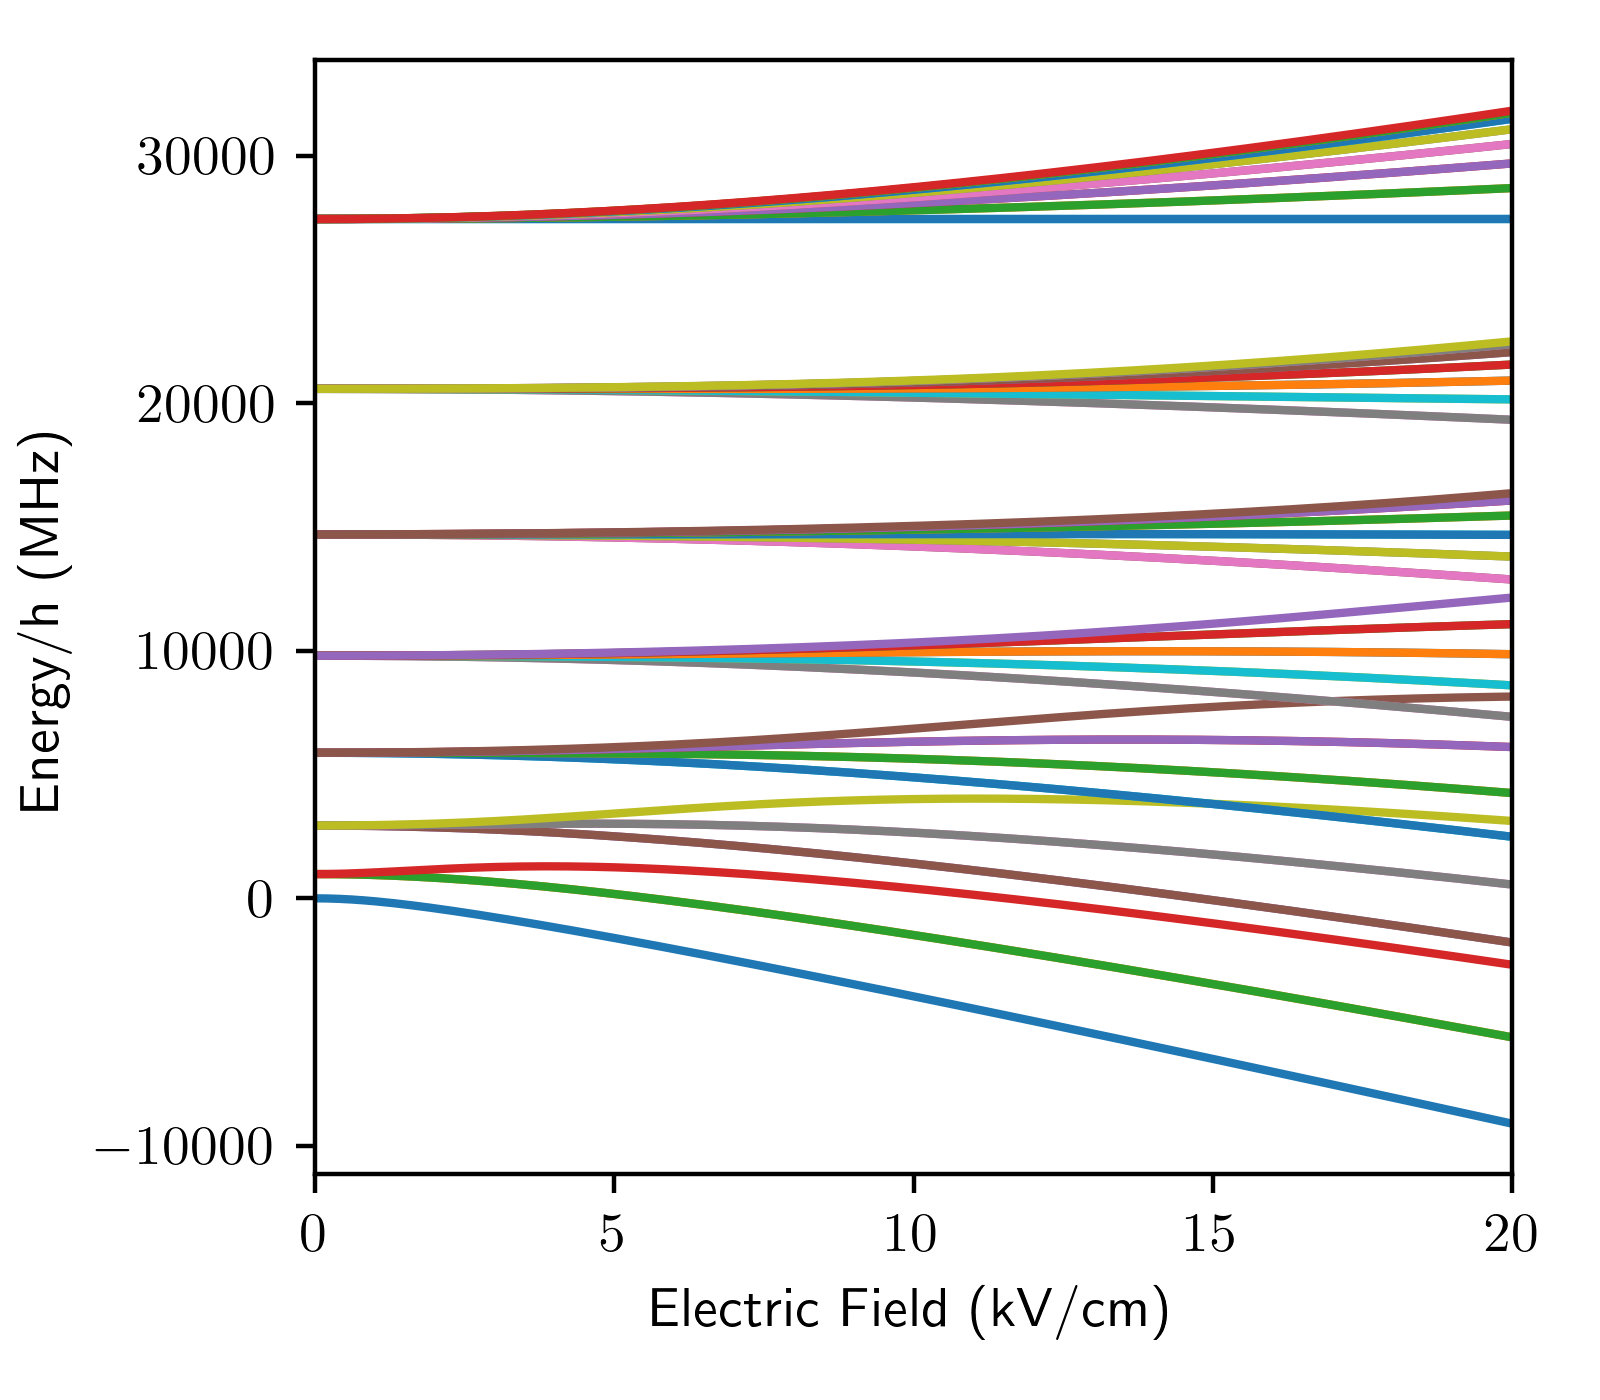

In [11]:
fig, ax = plt.subplots()

for i, N, M in state_iter(N_MAX):
    ax.plot(E * 1e-5, energies[:, i] * 1e-6 / scipy.constants.h)

ax.set_xlabel("Electric Field (kV/cm)")
ax.set_ylabel("Energy/h (MHz)")
ax.set_xlim(0, E_MAX)
fig.show()

# Generalised Units
We can generalise the above plot for any diatomic molecule with defining molecular parameters of $B_0$ and $d_0$.
Each line has the form:
$$E_{\tilde{N},M}(\epsilon) = E_{rot} + E_{DC} = B_0 \tilde{N} (\tilde{N}+1) + \epsilon d_0 f(\tilde{N},M_\tilde{N})$$
$$\implies  \left(\frac{1}{B_0}\right) E_{\tilde{N},M}(\epsilon) = \tilde{N} (\tilde{N}+1) + \epsilon  \left(\frac{d_0}{B_0}\right) f(\tilde{N},M_\tilde{N})$$
Therefore by plotting $E_{\tilde{N},M}$ in terms of $B_0$ and $\epsilon$ in terms of $B_0/d_0$ our graph will be independent of these molecular parameters
$$E_{\tilde{N},M}(\epsilon) =  B_0 E'_{\tilde{N},M}(\epsilon),\quad \epsilon =  \left(\frac{B_0}{d_0}\right) \epsilon'$$
$$\implies E'_{\tilde{N},M}(\epsilon) = \tilde{N} (\tilde{N}+1) + \epsilon' f(\tilde{N},M_\tilde{N})$$

<IPython.core.display.Javascript object>


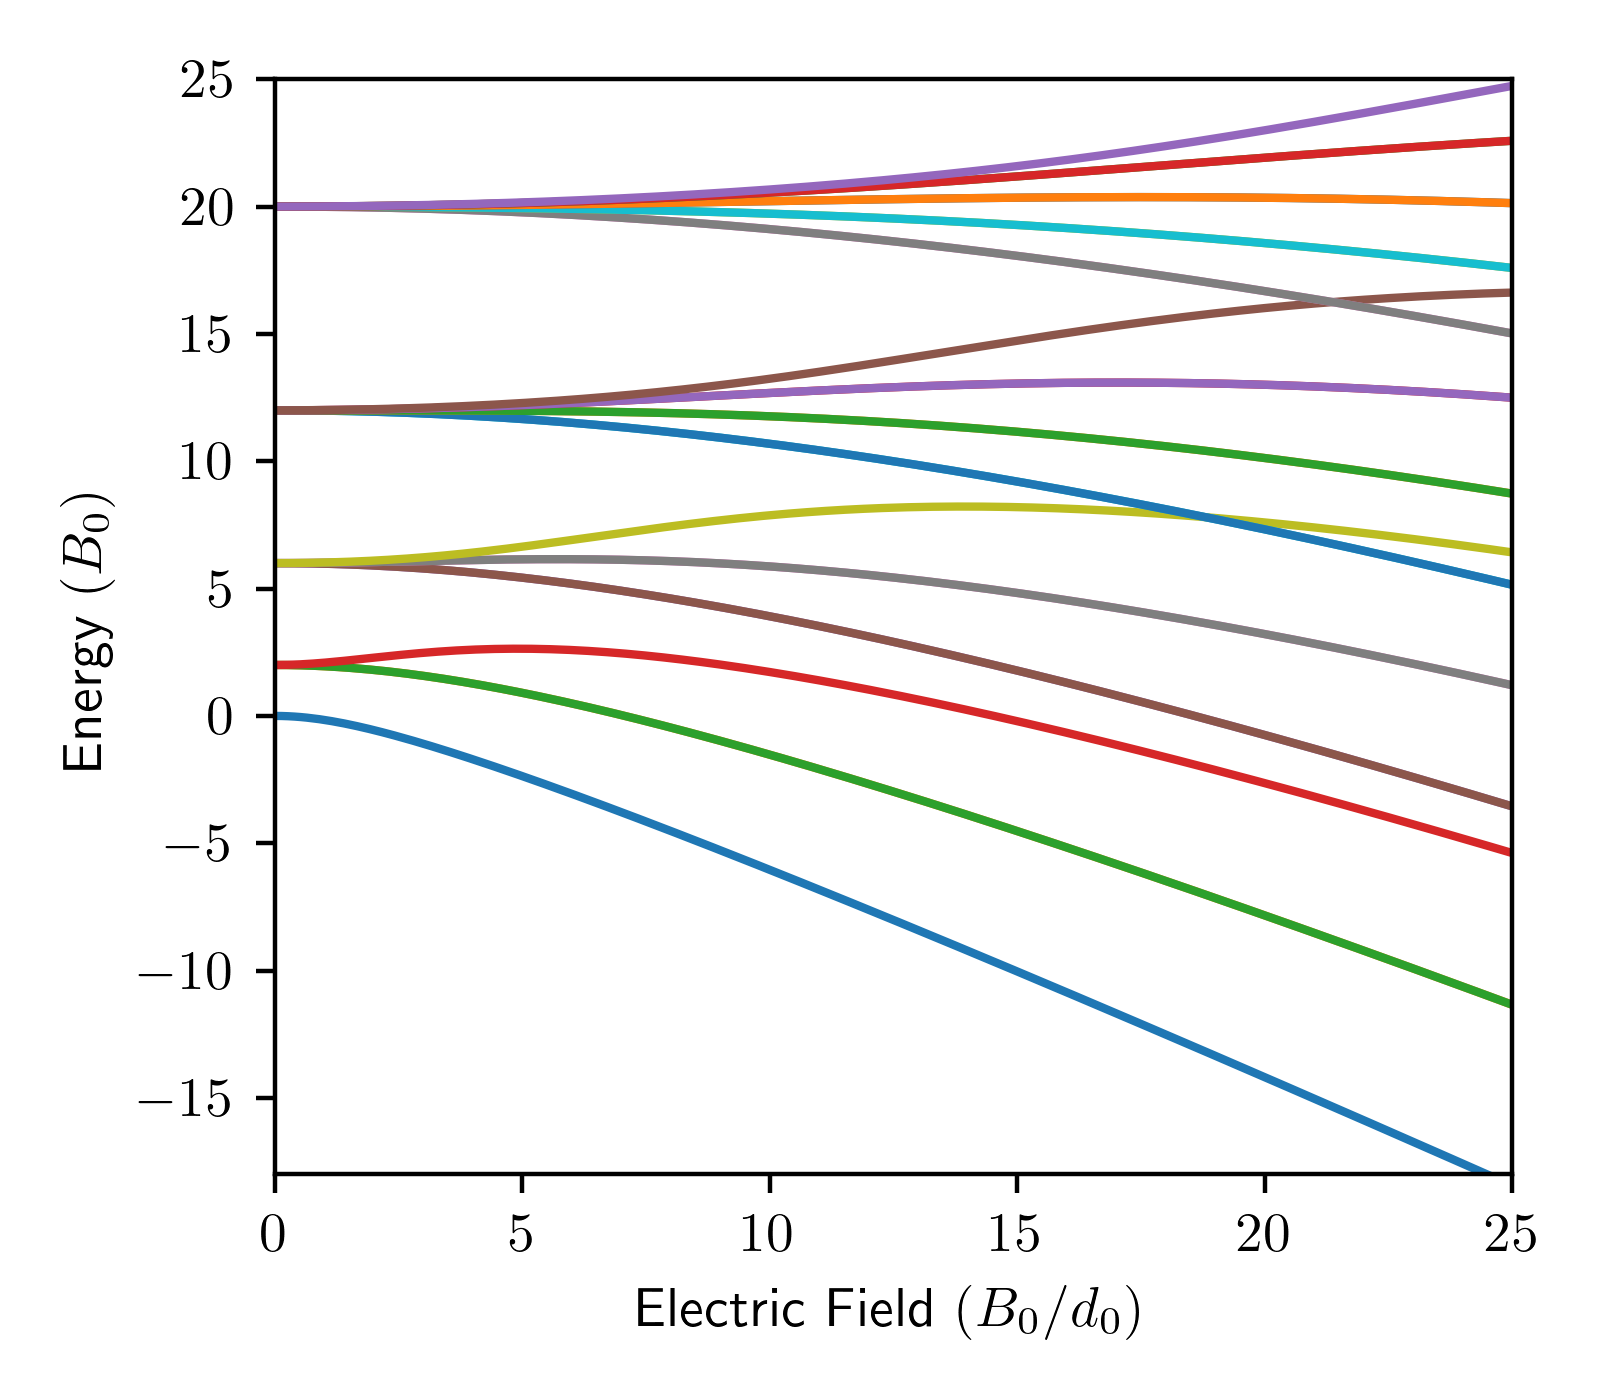

In [12]:
# Generalised Units code
fig, ax = plt.subplots()

for i, N, M in state_iter(N_MAX):
    ax.plot(E * (D_0 / B_0), energies[:, i] / B_0)

ax.set_xlabel("Electric Field $(B_0/d_0)$")
ax.set_ylabel("Energy $(B_0)$")
ax.set_xlim(0, 25)
ax.set_ylim(-18, 25)
fig.show()

# Lab frame Dipole Moments
We can get the lab frame expected dipole moments from the negative derivative of the energies.
$$
<\psi_i|d_z|\psi_i> = -\frac{d}{d\epsilon} <\psi_i|H|\psi_i> = -\frac{dE_i}{d\epsilon}
$$

<IPython.core.display.Javascript object>


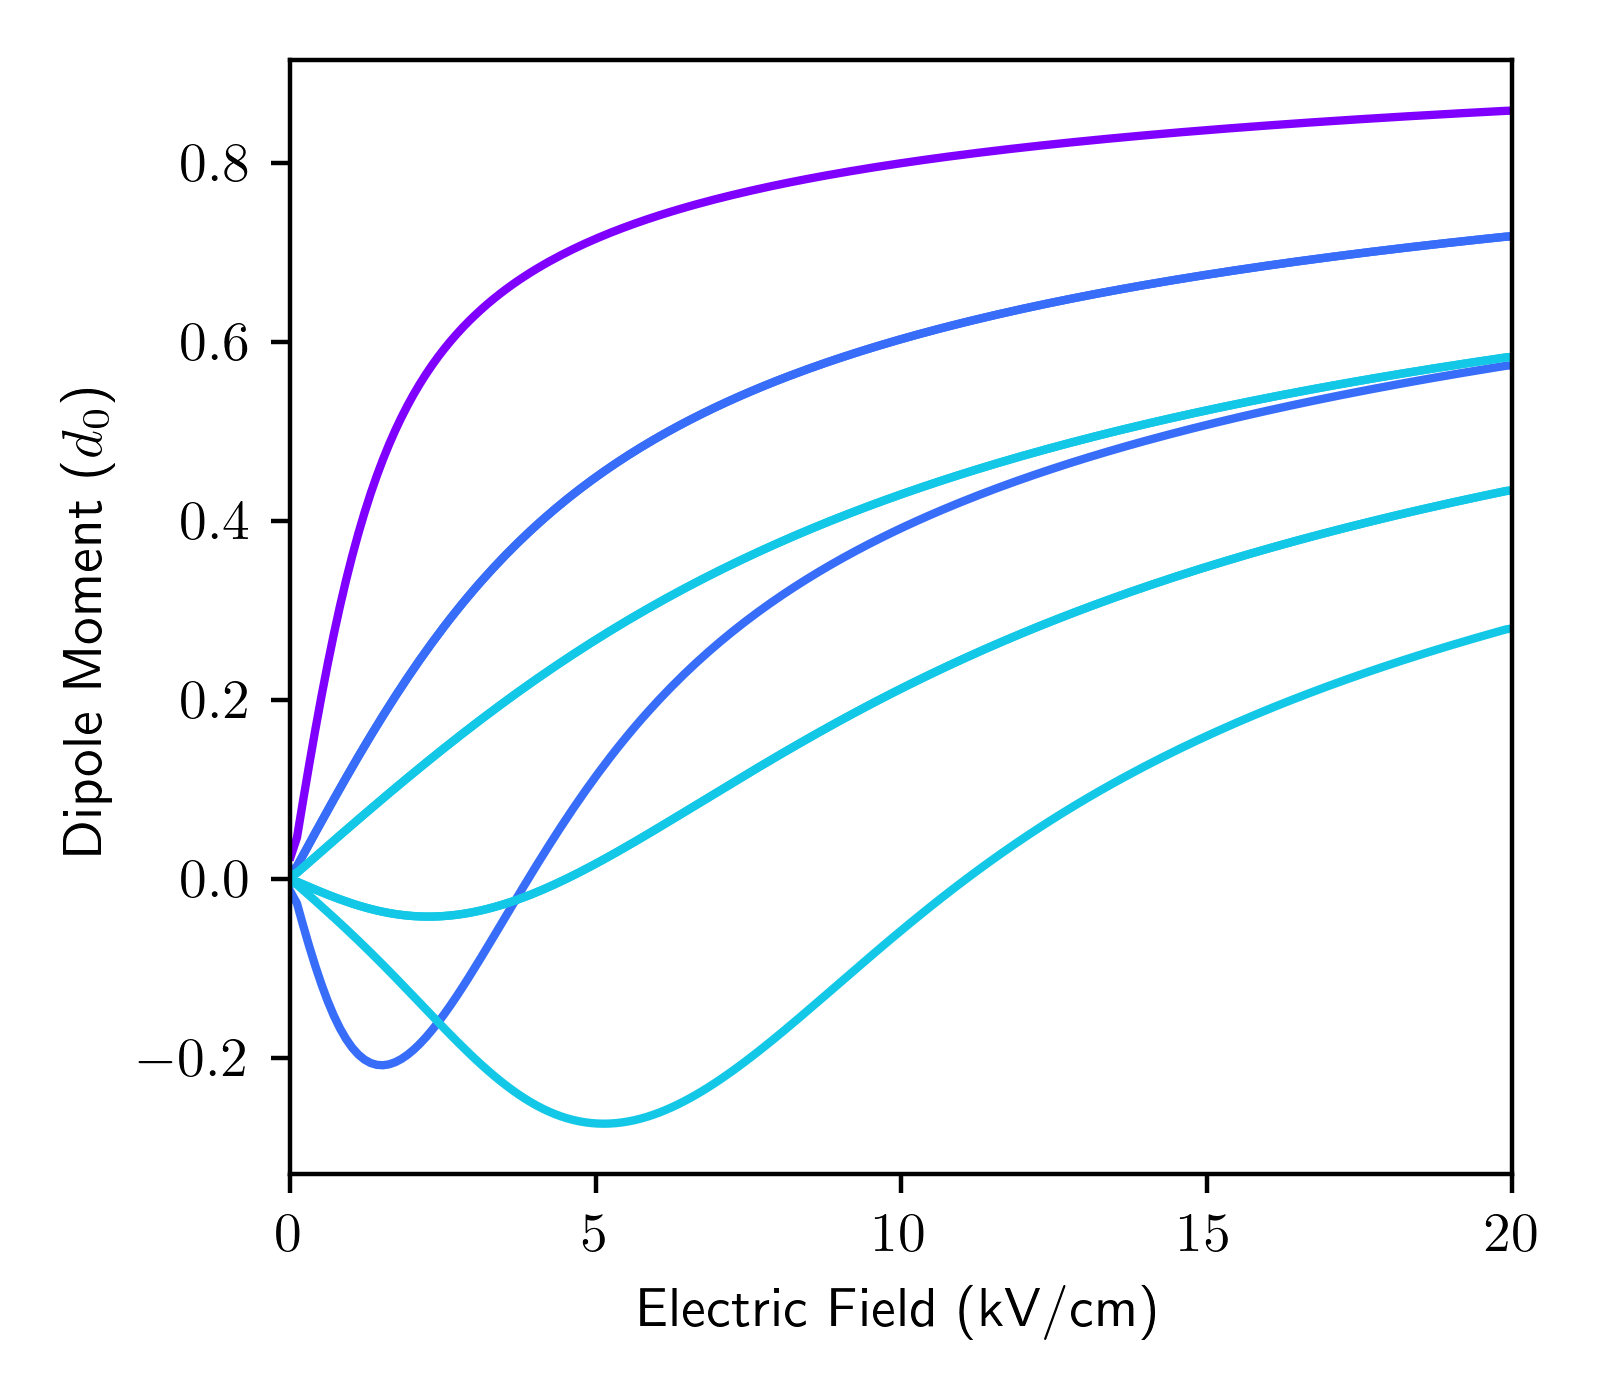

In [13]:
fig, ax = plt.subplots()

for i, N, M in state_iter(2):
    plt.plot(E * 1e-5, -np.gradient(energies[:, i], E) / D_0, color=N_COLOURS[N])

ax.set_xlabel("Electric Field (kV/cm)")
ax.set_ylabel("Dipole Moment ($d_0$)")
ax.set_xlim(0, E_MAX)
fig.show()

# Transition Dipole Moments
We can directly calculate the dipole matrix elements for $d_j=d_0 Y_{1,j}$, for $j=0,+1,-1$ representing different polarisations of light on the spherical harmonics:
$$
<N,M_N|d_j|N',M_N'> = d_0 \int\int Y_{N,M_N}^* Y_{1,j} Y_{N',M_N'} d^2\Omega
$$
Once again using the Wigner-3j coefficient symbols:
$$
<N,M_N|d_j|N',M_N'> = d_0 \sqrt{(2N+1)(2N'+1)} (-1)^{M_N}
\begin{pmatrix}
N & 1 & N'\\
-M_N & j & M_n'
\end{pmatrix}
\begin{pmatrix}
N & 1 & N'\\
0 & 0 & 0
\end{pmatrix}
$$
We can get the E field dependence by decomposing our new computed E-dependent eigenstates into spherical harmonics and summing the dipole operators for each.
$$
|N',M_N'> = \sum_{N=0}^{\infty}\sum_{M_N=-N}^{N} c_{M,M_N}Y_{M,M_N}
$$

<IPython.core.display.Javascript object>


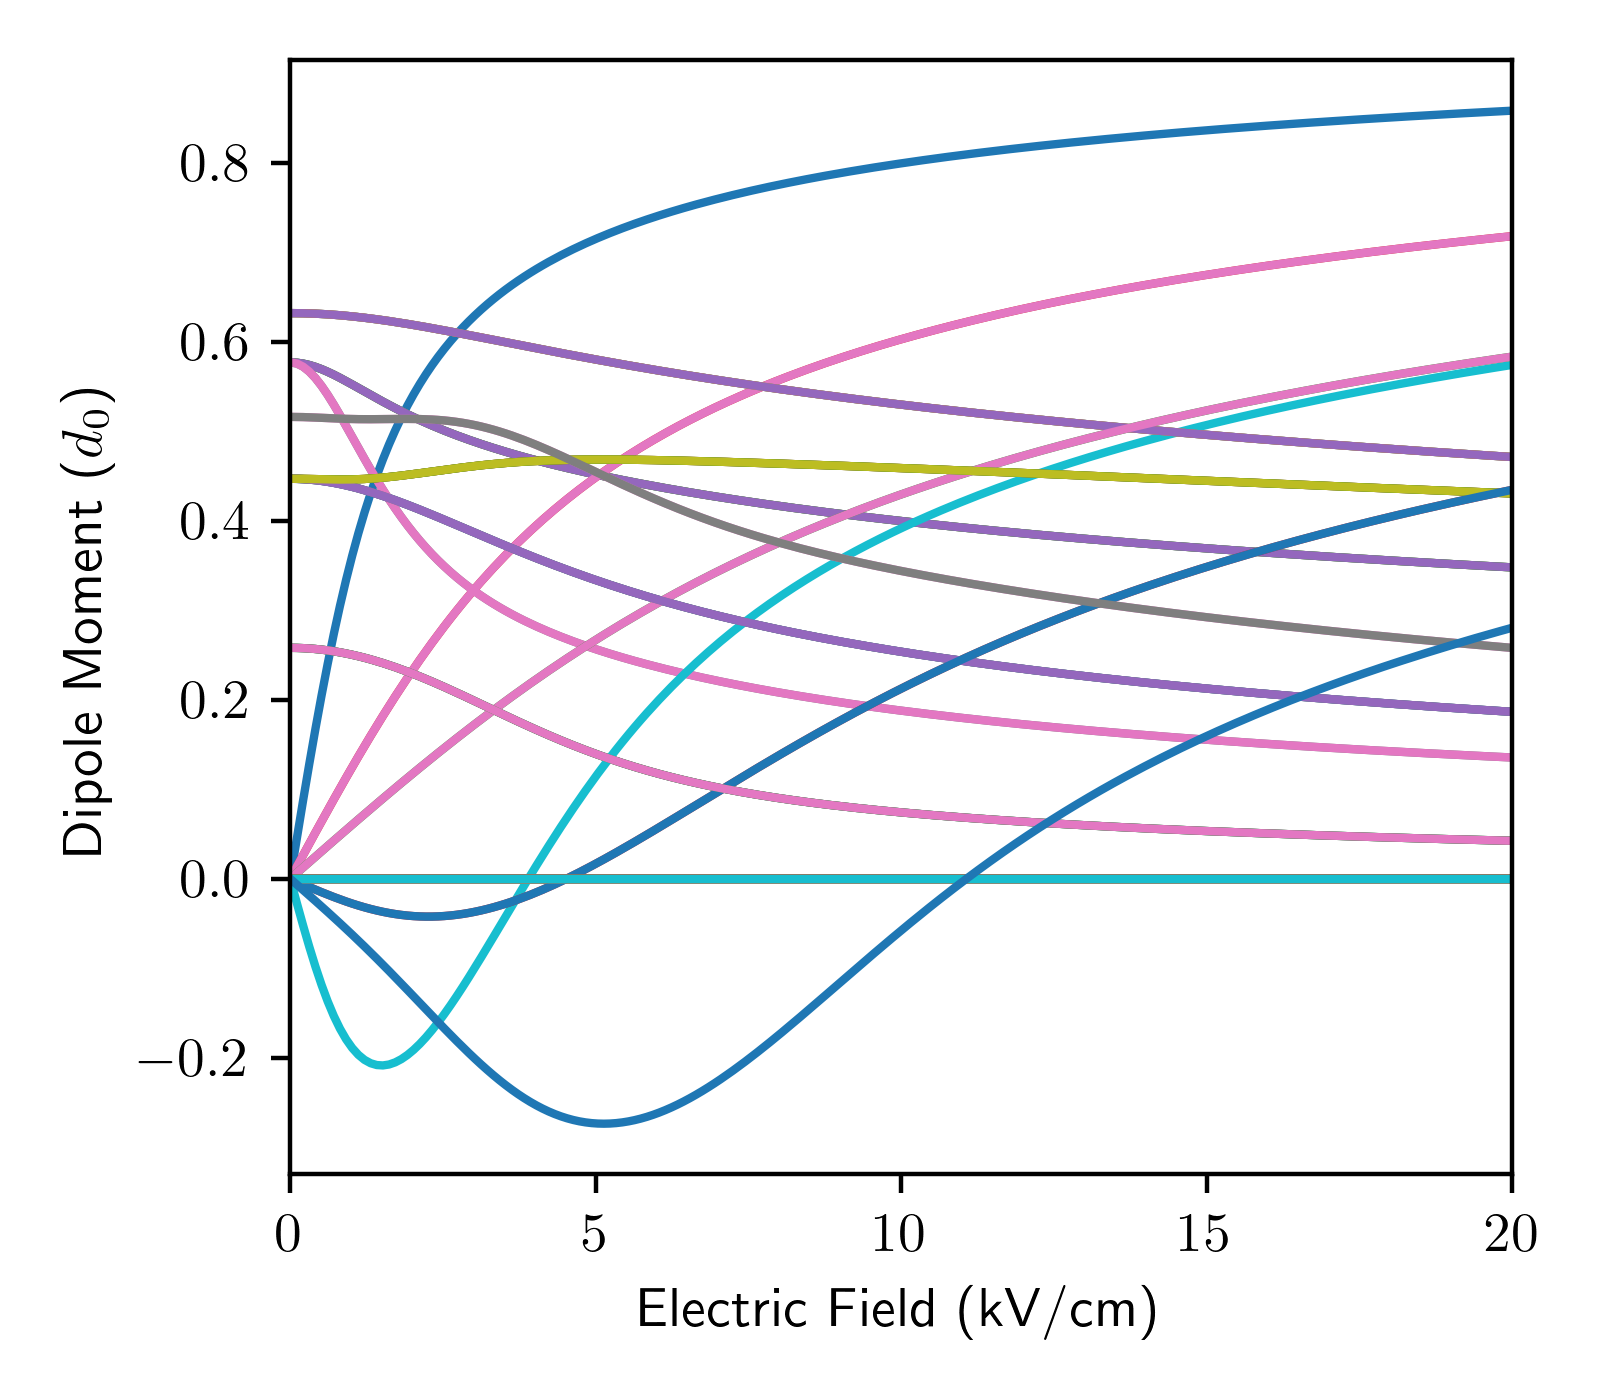

[((0, 0), 0, (0, 0)), ((0, 0), 0, (1, -1)), ((0, 0), 1, (1, -1)), ((0, 0), -1, (1, -1)), ((0, 0), 0, (1, 1)), ((0, 0), 1, (1, 1)), ((0, 0), -1, (1, 1)), ((0, 0), 0, (1, 0)), ((0, 0), 1, (1, 0)), ((0, 0), -1, (1, 0)), ((1, -1), 0, (0, 0)), ((1, -1), 1, (0, 0)), ((1, -1), -1, (0, 0)), ((1, -1), 0, (1, -1)), ((1, -1), 0, (2, -2)), ((1, -1), 1, (2, -2)), ((1, -1), -1, (2, -2)), ((1, -1), 0, (2, -1)), ((1, -1), 1, (2, -1)), ((1, -1), -1, (2, -1)), ((1, -1), 0, (2, 0)), ((1, -1), 1, (2, 0)), ((1, -1), -1, (2, 0)), ((1, 1), 0, (0, 0)), ((1, 1), 1, (0, 0)), ((1, 1), -1, (0, 0)), ((1, 1), 0, (1, 1)), ((1, 1), 0, (2, 2)), ((1, 1), 1, (2, 2)), ((1, 1), -1, (2, 2)), ((1, 1), 0, (2, 1)), ((1, 1), 1, (2, 1)), ((1, 1), -1, (2, 1)), ((1, 1), 0, (2, 0)), ((1, 1), 1, (2, 0)), ((1, 1), -1, (2, 0)), ((1, 0), 0, (0, 0)), ((1, 0), 1, (0, 0)), ((1, 0), -1, (0, 0)), ((1, 0), 0, (1, 0)), ((1, 0), 0, (2, -1)), ((1, 0), 1, (2, -1)), ((1, 0), -1, (2, -1)), ((1, 0), 0, (2, 1)), ((1, 0), 1, (2, 1)), ((1, 0), -1, (2

In [28]:
fig, ax = plt.subplots()

moments_to_show = [
    ((0, 0), 0, (0, 0)),
    ((1, 0), 0, (1, 0)),
    ((0, 0), 0, (1, 0)),
    ((1, 1), 0, (1, 1)),
    ((1, 1), 1, (0, 0)),
]

moments_to_show=[]
for i, N1, M1 in state_iter(2):
    for j, N2, M2 in state_iter(2):
        dN = N1-N2
        dM = M1-M2
        if dN == 0 and dM == 0:
            moments_to_show.append(((N1, M1), 0, (N2, M2)))
        elif abs(dN) == 1 and abs(dM) <= 1:
            moments_to_show.append(((N1, M1), 0, (N2, M2)))
            moments_to_show.append(((N1, M1), 1, (N2, M2)))
            moments_to_show.append(((N1, M1), -1, (N2, M2)))
print(moments_to_show)

moments_state_number = [
    (state_to_pos(N1, M1), state_to_pos(N2, M2), P)
    for (N1, M1), P, (N2, M2) in moments_to_show
]

# Get coefficients
for state_1, state_2, P in moments_state_number:
    this_dipole_moment = np.zeros(E_STEPS, dtype=np.cdouble)
    for i, N1, M1 in state_iter(N_MAX):
        for j, N2, M2 in state_iter(N_MAX):
            amp = np.conj(states[:, i, state_1]) * states[:, j, state_2]
            pre = (-1) ** M1 * np.sqrt((2 * N1 + 1) * (2 * N2 + 1))
            wig = complex(wigner_3j(N1, 1, N2, -M1, P, M2) * wigner_3j(N1, 1, N2, 0, 0, 0))
            this_dipole_moment += amp * pre * wig
    if state_1 != state_2: # Is this hacky?
        this_dipole_moment = np.abs(this_dipole_moment)
    ax.plot(E * 1e-5, this_dipole_moment)
ax.set_xlabel("Electric Field (kV/cm)")
ax.set_ylabel("Dipole Moment ($d_0$)")
ax.set_xlim(0, E_MAX)
#ax.set_ylim(-1.0, 1.0)
fig.show()

# Convergence depending on Energy level
The addition of a E-field mixes higher rotational states into lower rotational states. Because the matrix used to perform diagonalisation of our Hamiltonian is finite, it cannot have mixing of states past some N. We need to check values are convervent when leaving out these higher order rotational states

<IPython.core.display.Javascript object>


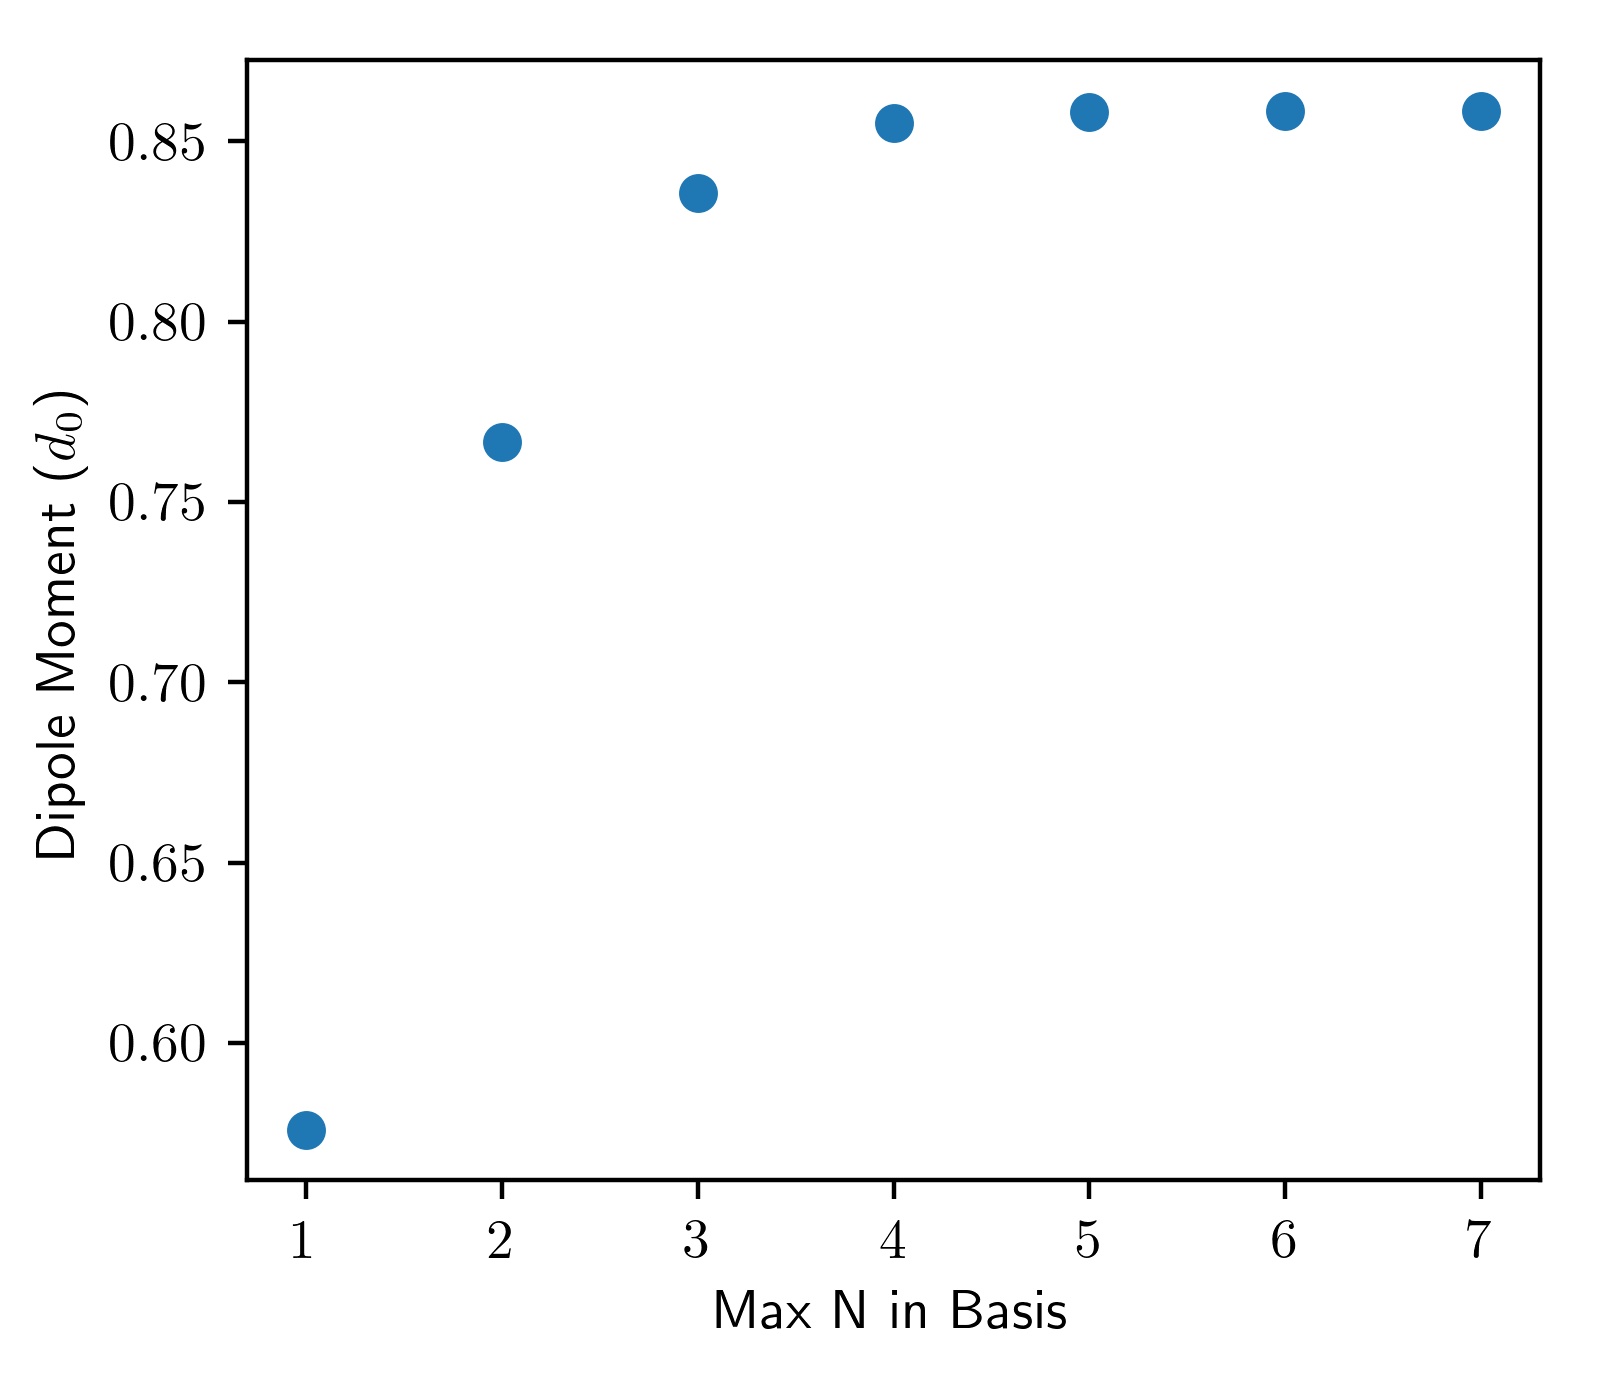

In [15]:
fig, ax = plt.subplots()

converged_dipoles = []
for N in range(1, N_MAX + 1):
    size = 1 + 2 * N + N**2
    convergence_Htot = Hrot[:size, :size, None] + Hdc[:size, :size, None] * E
    convergence_Htot = convergence_Htot.transpose(2, 0, 1)
    convergence_energies, convergence_states = eigh(convergence_Htot)
    convergence_dipoles = -np.gradient(convergence_energies[:, 0], E) / D_0
    converged_dipoles.append(convergence_dipoles[-2])

ax.scatter(list(range(1, N_MAX + 1)), converged_dipoles)
ax.set_xlabel("Max N in Basis")
ax.set_ylabel("Dipole Moment ($d_0$)")
fig.show()

# Plot Functions on a Sphere

In [16]:
# Polar and Azimuthal angles to Sample
theta = np.linspace(0, np.pi, POLAR_PLOT_RES)
phi = np.linspace(0, 2 * np.pi, POLAR_PLOT_RES)
# Create a 2-D meshgrid of (theta, phi) angles.
theta_grid, phi_grid = np.meshgrid(theta, phi)
# Calculate the unit sphere Cartesian coordinates of each (theta, phi).
xyz = np.array(
    [
        np.sin(theta_grid) * np.sin(phi_grid),
        np.sin(theta_grid) * np.cos(phi_grid),
        np.cos(theta_grid),
    ]
)


def f_sph_polar_to_cart_surf(f):
    f_grid = f(theta_grid, phi_grid)  # Evaluate function over grid
    fxs, fys, fzs = np.abs(f_grid) * xyz  # get final output cartesian coords
    return fxs, fys, fzs


def surface_plot(fxs, fys, fzs, ax):
    # Add axis lines
    ax_len = 0.5
    ax.plot([-ax_len, ax_len], [0, 0], [0, 0], c="0.5", lw=1, alpha=0.3)
    ax.plot([0, 0], [-ax_len, ax_len], [0, 0], c="0.5", lw=1, alpha=0.3)
    ax.plot([0, 0], [0, 0], [-ax_len, ax_len], c="0.5", lw=1, alpha=0.3)
    # Set axes limits
    ax_lim = 0.5
    ax.set_xlim(-ax_lim, ax_lim)
    ax.set_ylim(-ax_lim, ax_lim)
    ax.set_zlim(-ax_lim, ax_lim)
    # Set camera position
    ax.view_init(elev=15, azim=45)  # Reproduce view
    ax.set_xlim3d(-0.45, 0.45)  # Reproduce magnification
    ax.set_ylim3d(-0.45, 0.45)  # ...
    ax.set_zlim3d(-0.45, 0.45)  # ...
    # Turn off Axes
    ax.axis("off")
    # Draw
    ax.patch.set_alpha(0.0)
    ax.plot_surface(
        fxs, fys, fzs,
        rstride=1, cstride=1,
        cmap=plt.get_cmap("viridis"),
        linewidth=0,
        antialiased=False,
        alpha=0.3,
        shade=False,
    )

<IPython.core.display.Javascript object>


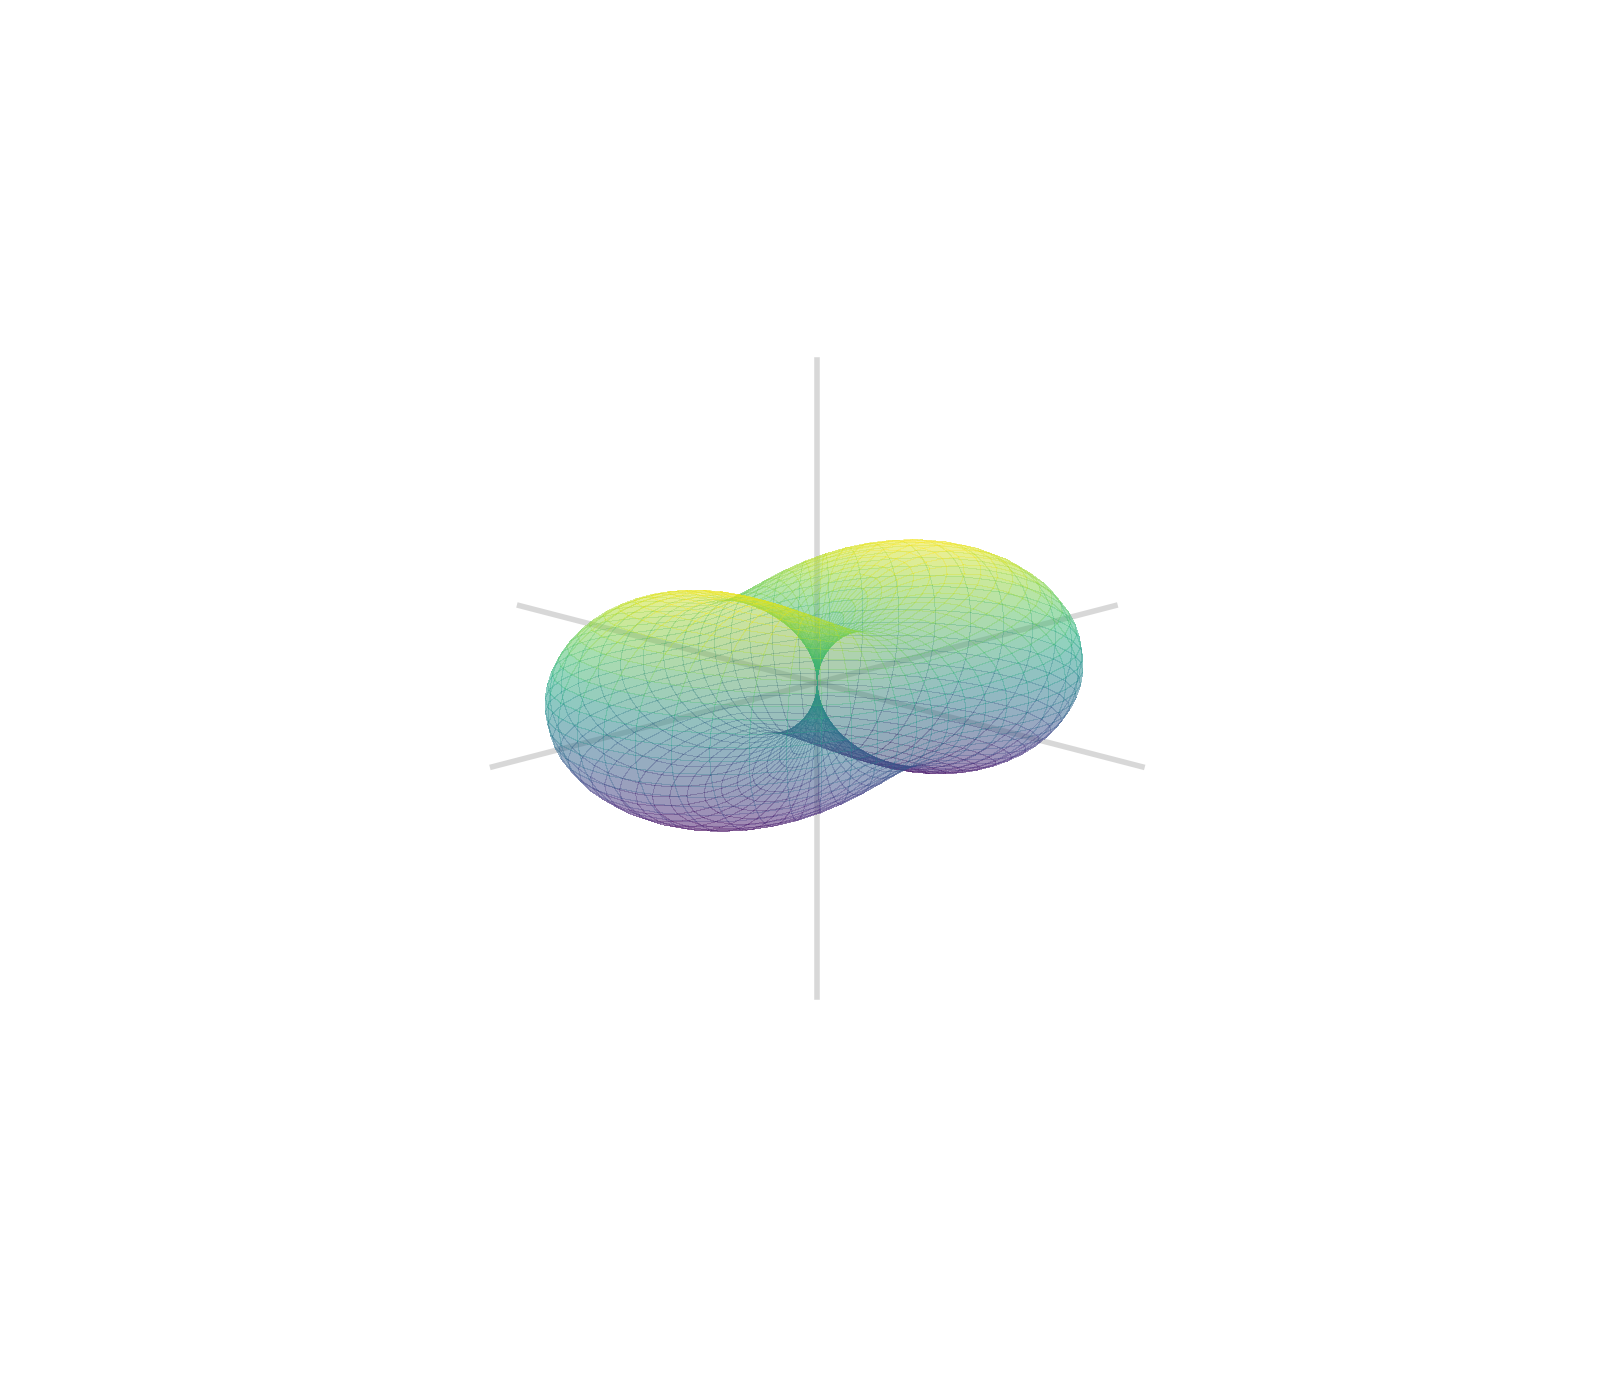

In [17]:
f = lambda theta_grid, phi_grid : 0.8*sph_harm(1, 1, phi_grid, theta_grid)+0.2*sph_harm(-1, 1, phi_grid, theta_grid)
fxs, fys, fzs = f_sph_polar_to_cart_surf(f)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface_plot(fxs, fys, fzs, ax)
fig.show()

# Plot the eigenstates under stark shift

In [18]:
def surface_plot_stark(e_number, state, ax):
    f_grid = np.zeros((POLAR_PLOT_RES, POLAR_PLOT_RES), dtype=np.cdouble)
    for i, N, M in state_iter(N_MAX):
        f_grid += states[e_number, i, state] * sph_harm(M, N, phi_grid, theta_grid)
    Yx, Yy, Yz = np.abs(f_grid) * xyz  # get final output cartesian coords
    surface_plot(Yx, Yy, Yz, ax)

<IPython.core.display.Javascript object>


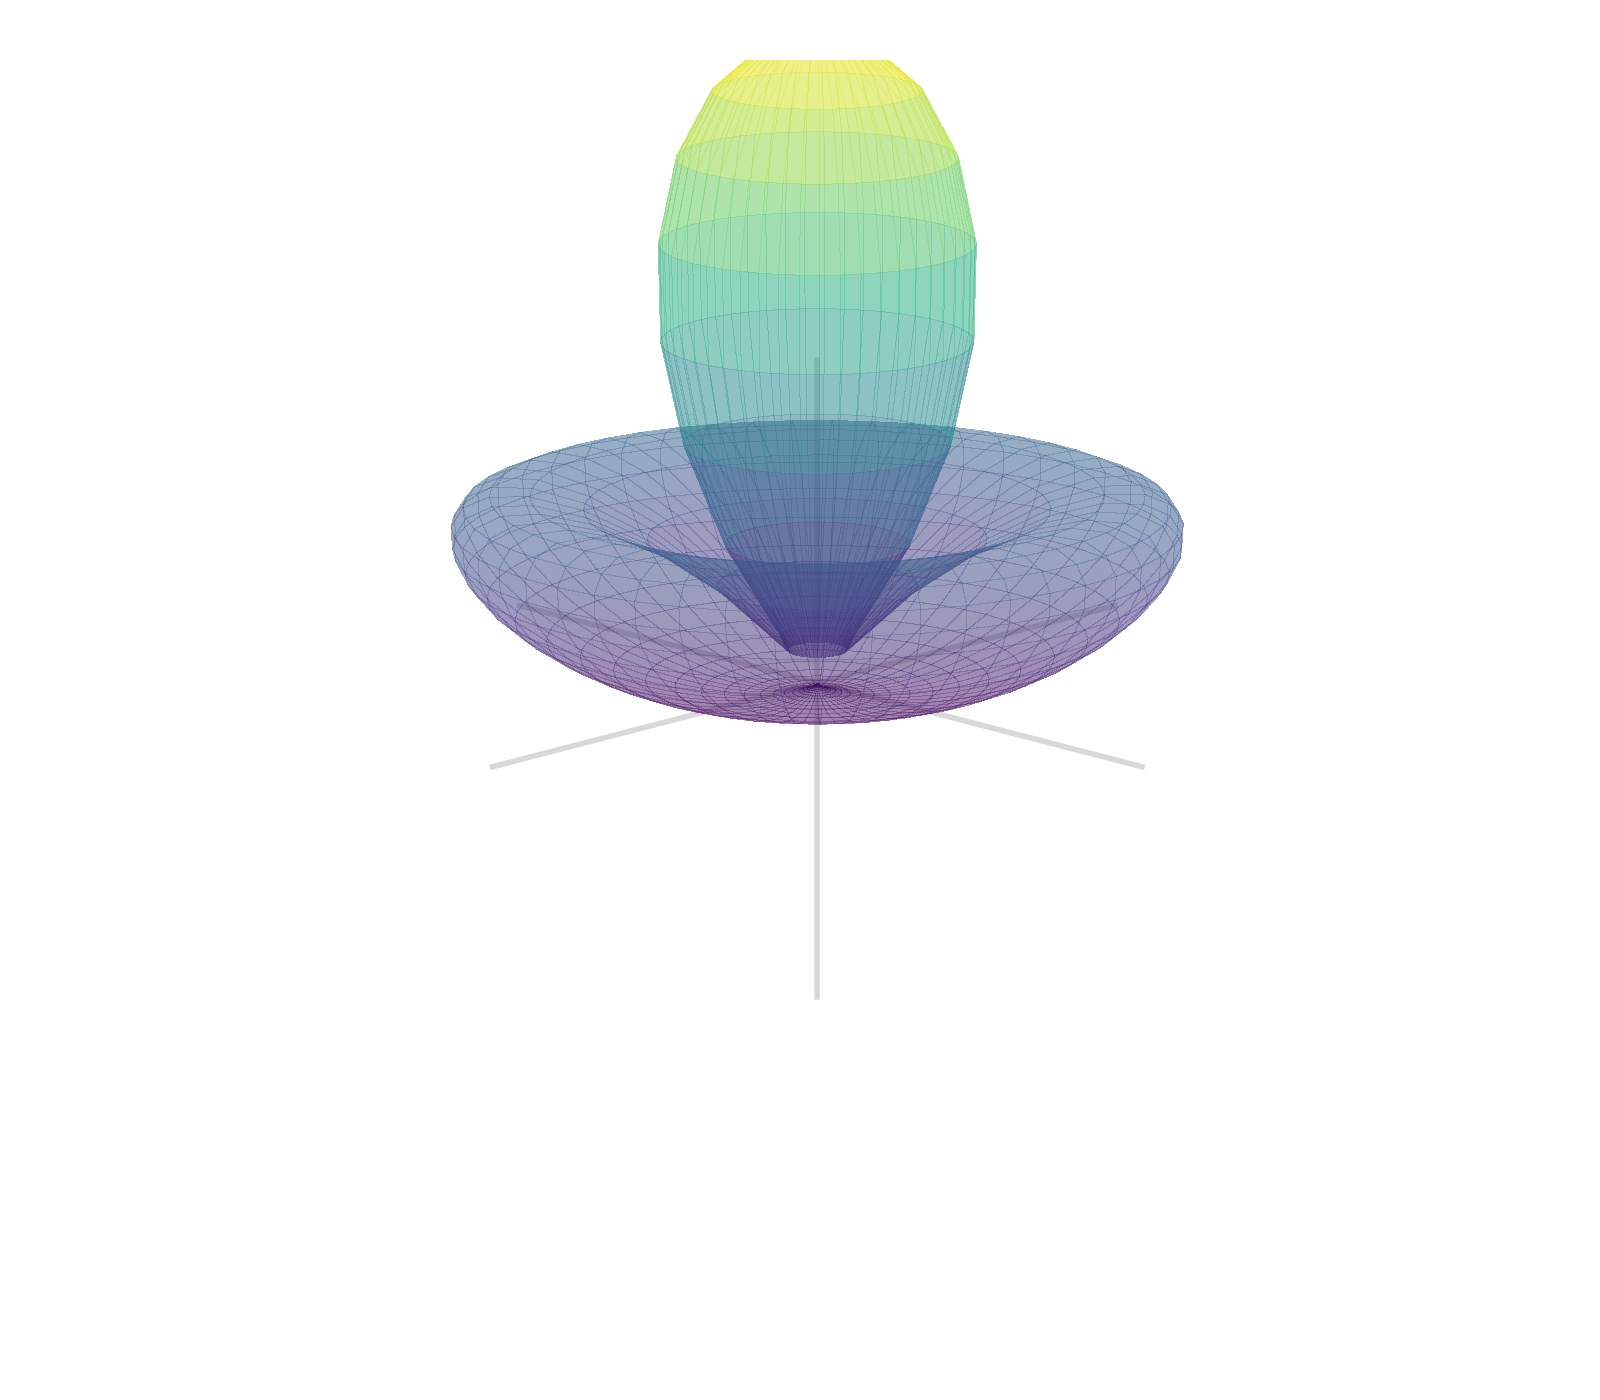

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface_plot_stark(E_STEPS - 1, 3, ax)
fig.show()

# E shifting Animation

<IPython.core.display.Javascript object>


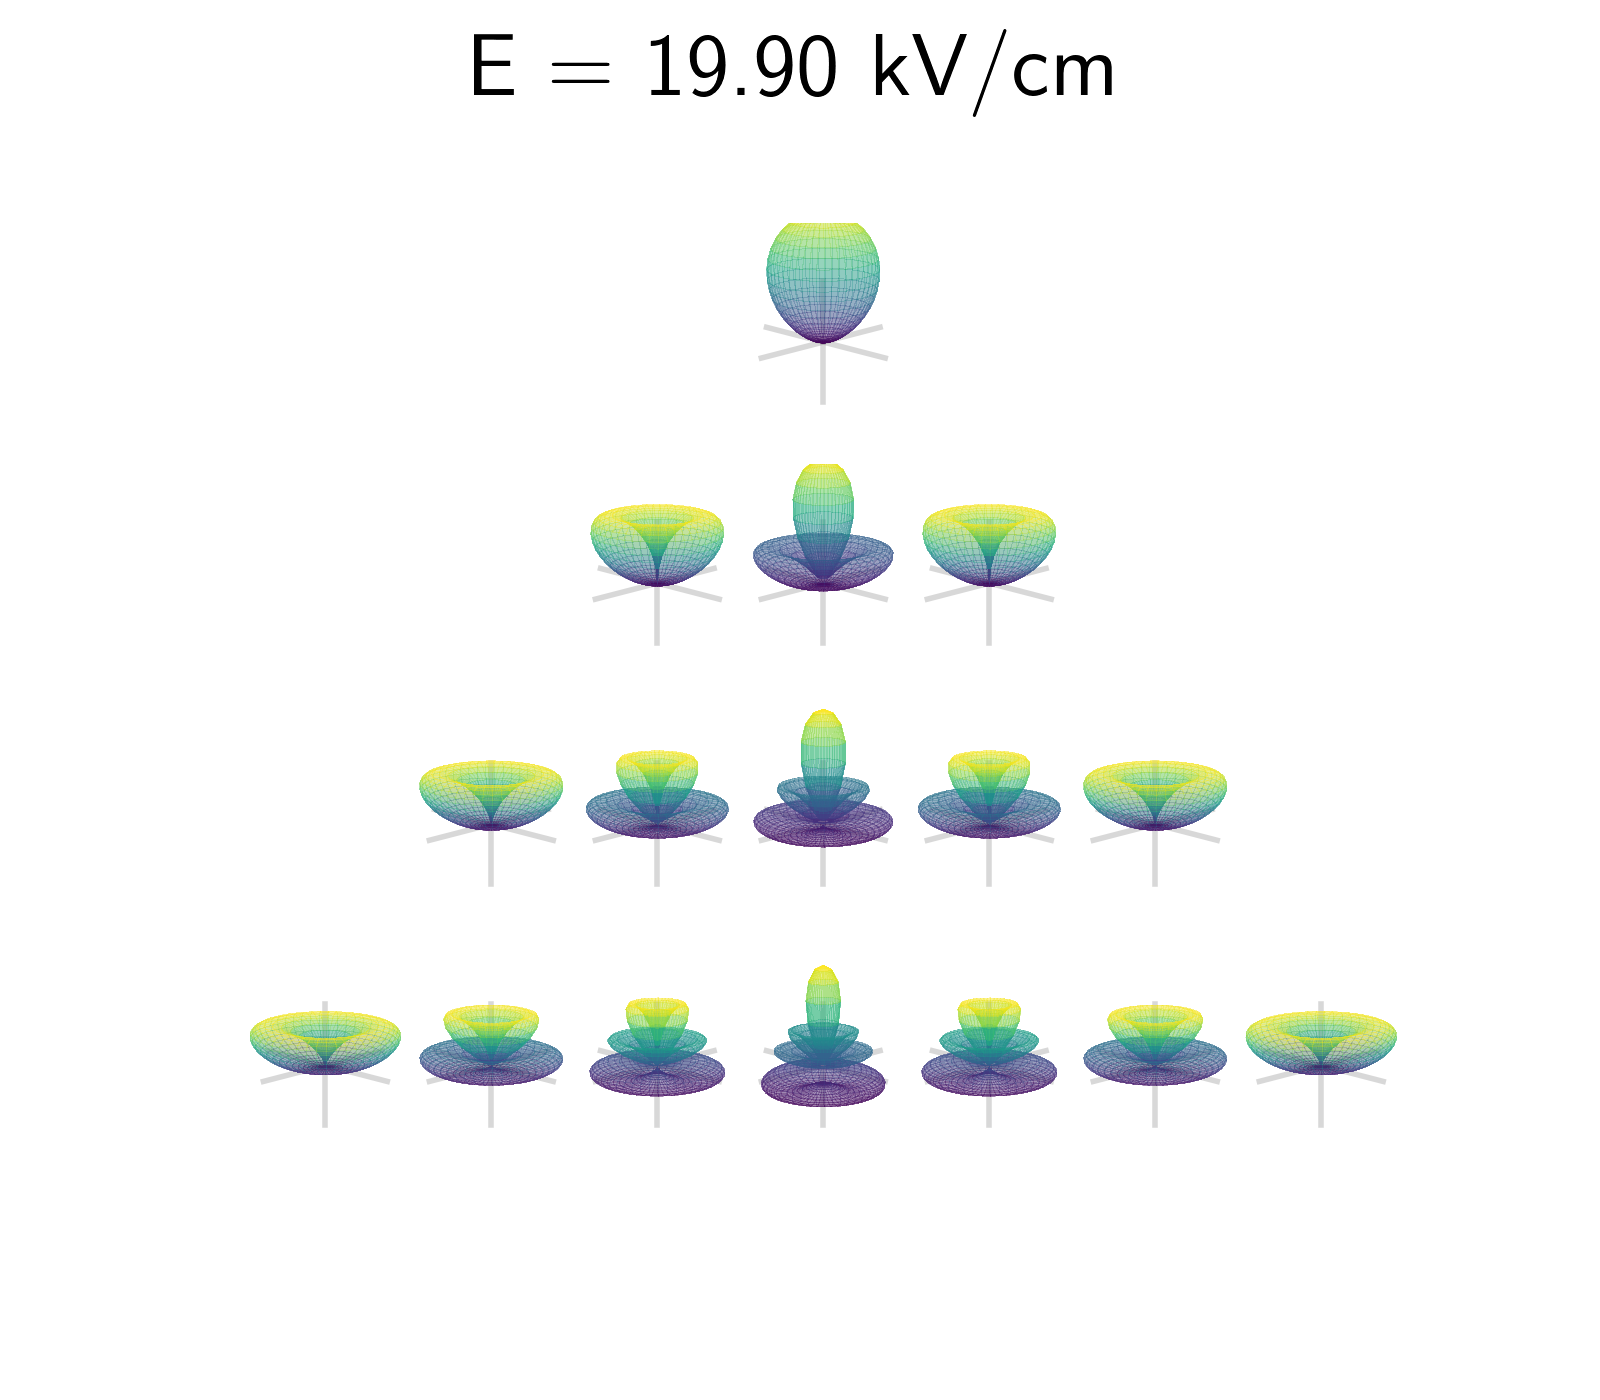

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_1694/3586557236.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(filename, dpi=400)
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_1694/3586557236.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(filename, dpi=400)


In [20]:
SHOW_NMAX = 3  # Change me

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2 * SHOW_NMAX + 1, nrows=SHOW_NMAX + 1, figure=fig, wspace=-0.32, hspace=-0.32)

for e_number in range(0, E_STEPS, E_STEPS - 2):
    fig.clf()

    for showi, showN, showM in state_iter(SHOW_NMAX):
        ax = fig.add_subplot(spec[showN, showM + SHOW_NMAX], projection="3d")
        surface_plot_stark(e_number, showi, ax)

    fig.suptitle(f"E = {E[e_number]*1e-5:.2f} kV/cm", fontsize=16)
    filename = f"animation/image{e_number:03}.png"
    fig.savefig(filename, dpi=400)
    fig.show()